# Simulating data for visualisation

In [1]:
import sys
import os

module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from itertools import product
from copy import deepcopy    

import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from app.utils.naming import component_to_csv_file, format_component_name
from stream import generate_streams, test_endpoints, get_token, register, test_endpoints

## Generation
All files require: date, name, sex, agegroup

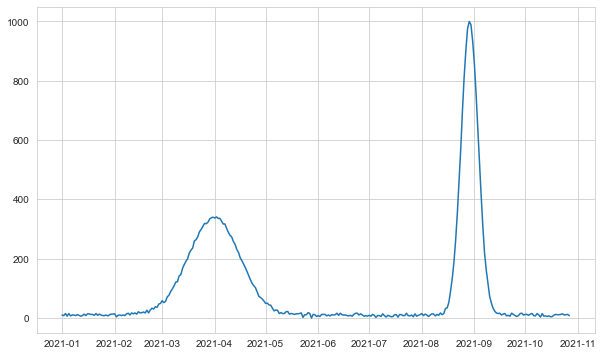

In [2]:
def generate_bimodal_data(y_min, y_max, size, width1='low', width2='high'):
    width_dict = {
        'low': 0.3, 'medium': 0.2, 'high': 0.1
    }
    width1 = width_dict[width1]
    width2 = width_dict[width2]
    
    loc1, scale1, size1 = (0, width1, 100)
    loc2, scale2, size2 = (3, width2, 100)
    x1 = np.random.normal(loc=loc1, scale=scale1, size=size1)
    x2 = np.random.normal(loc=loc2, scale=scale2, size=size2)
    x = np.concatenate([x1, x2])
    x = np.linspace(x.min() - 1, x.max() + 1, size)

    # y follows bimodal distribution
    y1 = norm.pdf(x, loc=loc1, scale=scale1) * float(size1) / x2.size 
    y2 = norm.pdf(x, loc=loc2, scale=scale2) * float(size2) / x2.size
    noise1 = np.random.normal(loc=loc1, scale=0.01, size=len(x))
    noise2 = np.random.normal(loc=loc2, scale=0.01, size=len(x))
    y = y1 + y2 + noise1 + noise2

    # Convert to desired range
    y = (y - y.min()) / (y.max() - y.min()) * (y_max - y_min) + y_min
    return y.astype(int)

n_days = 300
days = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')[:n_days]
x = days[:300]
y = generate_bimodal_data(0, 1000, 300, width1='low', width2='high')
fig = plt.figure(figsize=(10, 6))
plt.plot(x, y)

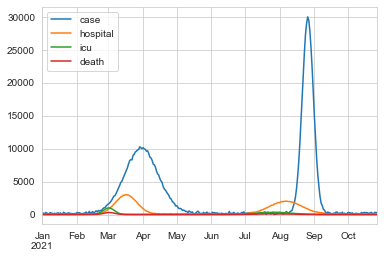

In [16]:
df = pd.DataFrame(index=days, data={
    'case': generate_bimodal_data(0, 30000, n_days, width1='low', width2='high'),
    'hospital': generate_bimodal_data(0, 3000, n_days, width1='medium', width2='low'),
    'icu': generate_bimodal_data(0, 1000, n_days, width1='high', width2='low'),
    'death': generate_bimodal_data(0, 300, n_days, width1='high', width2='low')
})
df.plot()

In [19]:
def to_df(dates, data_params, fields):
    """Return a dataframe with given index, values and static pair of keys, values.
    """
    dfs = []
    for values in product(*fields.values()):
        df = pd.DataFrame(data={'date': dates})
        for k,v in data_params.items():
            df[k] = generate_bimodal_data(*v)
        for k,v in zip(fields.keys(), values):
            df[k] = v
        dfs.append(df)
        
    df = pd.concat(dfs, ignore_index=True)
    df = df.sort_values(['date'] + list(fields.keys()))
    return df

fields = {
    'name': ['Ayrshire and Arran', 'Borders', 'Dumfries and Galloway', 'Fife', 'Forth Valley', 'Grampian', 'Greater Glasgow and Clyde', 
             'Highland', 'Lanarkshire', 'Lothian', 'Orkney', 'Shetland', 'Tayside', 'Western Isles'],
    'sex': ['female', 'male'],
    'agegroup': ['0', '1-14', '15-44', '45-64', '65-74', '75-84', '85+']
}

data_params = {
    'case': [0, 30000, n_days, 'low', 'high'],
    'hospital': [0, 3000, n_days, 'medium', 'low'],
    'icu': [0, 1000, n_days, 'high', 'low'],
    'death': [0, 300, n_days, 'high', 'low']
}

df = to_df(days, data_params, fields)

,date,case,hospital,icu,death,name,sex,agegroup
0,2021-01-01,171,99,10,2,Ayrshire and Arran,female,0
300,2021-01-01,380,34,8,1,Ayrshire and Arran,female,1-14
600,2021-01-01,379,45,15,3,Ayrshire and Arran,female,15-44
900,2021-01-01,343,51,10,3,Ayrshire and Arran,female,45-64
1200,2021-01-01,108,60,11,4,Ayrshire and Arran,female,65-74
...,...,...,...,...,...,...,...,...
57599,2021-10-27,430,80,11,2,Western Isles,male,15-44
57899,2021-10-27,294,89,15,3,Western Isles,male,45-64
58199,2021-10-27,122,72,11,3,Western Isles,male,65-74
58499,2021-10-27,175,39,9,3,Western Isles,male,75-84


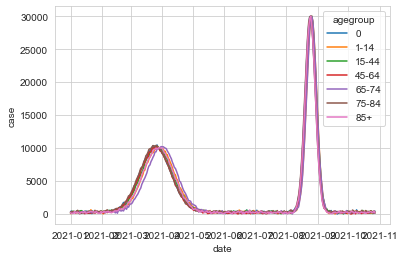

In [20]:
display(df)
sns.lineplot(data=df.query('name=="Fife" & sex=="female"'), x='date', y='case', hue='agegroup')

In [21]:
df.to_csv('../../data/live/simulated/scotland/daily_nhsboard_sex_agegroup_common.csv', index=None)

## Registration

### Generate manifest

In [7]:
manifest = {
    "product": "simulated/scotland",
    "components": [
        {
            "name": "daily_nhsboard_sex_agegroup_common",
            "dataType": "timeseries",
            "keywords": ["simulated", "scotland", "daily", "sex", "agegroup", "cases", "hospital", "icu"]
        }
    ]
}

for n in fields['name']:
    component = deepcopy(manifest['components'][0])
    component['keywords'].append(format_component_name(n))
    component['keys'] = 'name'
    component['values'] = n
    component['format'] = 'long'
    manifest['components'].append(component)
    
assert len(manifest.keys()) == 2
assert len(manifest['components']) == 15

### Generate stream objects

In [8]:
streams = generate_streams([manifest], split=False)

In [10]:
test_endpoints(streams)

In [9]:
token = get_token(prod=True)

In [11]:
for s in streams:
    register(s, token, prod=True)